## Setup: Import Required Modules

In [3]:
# Import and reload modules to get latest changes
import importlib
import sys

# Remove cached modules to force reload
for module in list(sys.modules.keys()):
    if 'analog_simulator' in module or 'digital_resource_estimator' in module or 'report_generator' in module:
        del sys.modules[module]

from library.analog_simulator import AnalogSimulator, AnalogSimulatorConfig
from library.digital_resource_estimator import DigitalResourceEstimator, DigitalResourceConfig
from library.report_generator import generate_comparison_report, print_report
import numpy as np
import matplotlib.pyplot as plt

# Set up plotting style
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

## Example 1: Basic Workflow

### Step 1: Configure Analog Quantum Simulator

We start by defining the system size and T1 coherence times. Analog quantum simulation has no discrete gates—only continuous-time evolution constrained by T1 decoherence.

In [12]:
# Configure analog simulator
analog_config = AnalogSimulatorConfig(
    circuit_width=100,           # Number of qubits
    default_t1=100.0,            # T1 time per qubit (μs)
    measurement_error_rate=0.01, # 1% measurement error
    target_fidelity=0.99,        # Target 99% fidelity
    max_runtime_multiplier=0.5   # Conservative: use T1/2 for max runtime
)

print("Analog Configuration:")
print(f"  System Size: {analog_config.circuit_width} qubits")
print(f"  T1 per qubit: {analog_config.default_t1} μs")
print(f"  Target fidelity: {analog_config.target_fidelity}")

Analog Configuration:
  System Size: 100 qubits
  T1 per qubit: 100.0 μs
  Target fidelity: 0.99


### Step 2: Instantiate Analog Simulator and Extract Feasible Runtime

In [13]:
# Create analog simulator
analog_sim = AnalogSimulator(analog_config)

print("Analog Simulation Results:")
print("="*60)
print(f"System T1 (effective):     {analog_sim.system_t1:.2f} μs")
print(f"Feasible runtime:          {analog_sim.feasible_runtime:.2f} μs")
print(f"                           {analog_sim.feasible_runtime_ms:.2f} ms")
print(f"                           {analog_sim.feasible_runtime_seconds:.6f} s")
print(f"\nError Analysis:")
print(f"  Decoherence error:       {analog_sim.get_decoherence_error():.6f}")
print(f"  Total error:             {analog_sim.get_total_error():.6f}")
print(f"  Fidelity:                {analog_sim.get_fidelity():.4f}")
print("="*60)

Analog Simulation Results:
System T1 (effective):     1.00 μs
Feasible runtime:          0.50 μs
                           0.00 ms
                           0.000000 s

Error Analysis:
  Decoherence error:       0.393469
  Total error:             0.393469
  Fidelity:                0.6065


### Step 3: Configure Digital Resource Estimator

Now we configure the digital fault-tolerant computation with error correction.

In [18]:
# Configure digital resource estimator
digital_config = DigitalResourceConfig(
    logical_qubits=100,                    # Same logical qubit count
    target_runtime=analog_sim.feasible_runtime,  # Match analog runtime
    digital_error_rate=0.001,              # Physical error rate
    target_logical_error_rate=1e-10,       # Target logical error rate
    t_gate_count=100,                      # Number of T gates (non-Clifford)
    magic_state_overhead_factor=2.0,       # Magic state cultivation overhead
    compilation_overhead_factor=1.5,       # Routing/compilation overhead
    physical_gate_time=0.1                 # 100 ns per physical gate
)

print("Digital Configuration:")
print(f"  Logical qubits: {digital_config.logical_qubits}")
print(f"  Target runtime: {digital_config.target_runtime:.2f} μs")
print(f"  Physical error rate: {digital_config.digital_error_rate}")
print(f"  Target logical error rate: {digital_config.target_logical_error_rate:.0e}")
print(f"\nAuto-calculated parameters:")
print(f"  Code distance: {digital_config.code_distance}")
print(f"  Physical qubits per logical: {digital_config.qubits_per_logical}")

Digital Configuration:
  Logical qubits: 100
  Target runtime: 0.50 μs
  Physical error rate: 0.001
  Target logical error rate: 1e-10

Auto-calculated parameters:
  Code distance: 21
  Physical qubits per logical: 882


### Step 4: Wall-Clock Time Analysis (T-Gate Based)

In [19]:
# Create digital resource estimator
digital_est = DigitalResourceEstimator(digital_config)

print("Digital Resource Estimation:")
print("="*60)
print(f"Resource Breakdown:")
print(f"  Data qubits:             {digital_est.data_qubits:,}")
print(f"  Magic state qubits:      {digital_est.magic_state_qubits:,}")
print(f"  Compilation qubits:      {digital_est.compilation_qubits:,}")
print(f"  TOTAL physical qubits:   {digital_est.total_physical_qubits:,}")
print(f"\nError Correction Parameters:")
print(f"  Physical gate time:      {digital_config.physical_gate_time} μs")
print(f"  Code distance:           {digital_config.code_distance}")
print(f"  Physical qubits/logical: {digital_config.qubits_per_logical}")
print(f"\nTarget Algorithm:")
print(f"  Target runtime:          {digital_config.target_runtime:.2f} μs")
print(f"  Logical error rate:      {digital_est.get_logical_error_rate():.2e}")
print("="*60)

Digital Resource Estimation:
Resource Breakdown:
  Data qubits:             88,200
  Magic state qubits:      176,400
  Compilation qubits:      44,100
  TOTAL physical qubits:   308,700

Error Correction Parameters:
  Physical gate time:      0.1 μs
  Code distance:           21
  Physical qubits/logical: 882

Target Algorithm:
  Target runtime:          0.50 μs
  Logical error rate:      1.00e-12


In [20]:
import pandas as pd

print("\n" + "="*100)
print("WALL-CLOCK TIME: T-Gate Based Analysis")
print("="*100)

print("\n📚 SURFACE CODE QEC PARAMETERS (from literature):")
print("-"*100)

# Physical parameters
physical_gate_time_us = 0.1   # 100 ns per gate
t_cycle_us = 1.0              # Syndrome extraction cycle time
code_distances = [21, 25, 30]

print(f"  Physical gate time:      {physical_gate_time_us} μs")
print(f"  QEC cycle time:          {t_cycle_us:.0f} μs (per syndrome round)")
print(f"  Code distances:          d = {code_distances}")

print("\n" + "-"*100)
print("FORMULA: T_wall = N_T × d × t_cycle")
print("         where N_T = number of T gates (non-Clifford operations)")
print("-"*100)

# Realistic scenarios: different circuit depths
scenarios = [
    {"name": "Shallow (few T gates)", "n_t": 100, "logical_time_us": 0.5},
    {"name": "Typical Trotter", "n_t": 1000, "logical_time_us": 0.5},
    {"name": "Deep Trotter", "n_t": 5000, "logical_time_us": 2.5},
    {"name": "Complex algorithm", "n_t": 10000, "logical_time_us": 5.0},
]

print("\n" + "="*100)
print("WALL-CLOCK TIME FOR DIFFERENT CIRCUIT DEPTHS")
print("="*100)

results = []
for scenario in scenarios:
    n_t = scenario["n_t"]
    logical_time = scenario["logical_time_us"]
    
    for d in code_distances:
        # Wall-clock time formula: N_T × d × t_cycle
        wall_clock_us = n_t * d * t_cycle_us
        wall_clock_ms = wall_clock_us / 1e3
        wall_clock_s = wall_clock_us / 1e6
        
        # Slowdown factor
        slowdown = wall_clock_us / logical_time if logical_time > 0 else 0
        
        results.append({
            "Scenario": scenario["name"],
            "N_T": f"{n_t:,}",
            "d": d,
            "Logical (μs)": logical_time,
            "Wall-Clock (μs)": f"{wall_clock_us:.0f}",
            "Wall-Clock (ms)": f"{wall_clock_ms:.2f}",
            "Slowdown": f"{slowdown:.0f}×",
        })

df = pd.DataFrame(results)
print("\n" + df.to_string(index=False))

print("\n" + "="*100)
print("KEY INSIGHTS")
print("="*100)
print("""
1. WALL-CLOCK TIME SCALING:
   • Scales linearly with N_T (number of T gates)
   • Scales linearly with d (code distance)
   • Total: T_wall = N_T × d × t_cycle ≈ N_T × d × 1 μs
   
2. REALISTIC ESTIMATES:
   • Shallow circuit (100 T gates):     ~2-3 ms wall-clock
   • Typical Trotter (1000 T gates):    ~20-30 ms wall-clock
   • Deep Trotter (5000 T gates):       ~100-150 ms wall-clock
   • Complex algorithm (10,000 T gates): ~200-300 ms wall-clock
   
3. ANALOG vs DIGITAL COMPARISON:
   
   Algorithm: 0.5 μs Hamiltonian evolution
   ────────────────────────────────────────
   Analog (no QEC):
     • Wall-clock: 0.5 μs
     • Qubits: ~100
     • No error correction
     
   Digital + QEC (Typical Trotter ~1000 T gates):
     • Wall-clock: ~25 ms (d=25)
     • Qubits: ~100,000 (with error correction)
     • Achieves p_L ≲ 10⁻¹⁰ logical error
     
   Slowdown: 50,000× longer wall-clock time
   
4. WHEN DOES DIGITAL WIN?
   
   When runtime needed > T1 limit:
   • Analog limited to ~50-100 μs (T1 coherence)
   • Digital can run arbitrarily long with error correction
   • For circuits deeper than T1 limit, digital is necessary
""")

print("\n" + "="*100)
print("TYPICAL CROSSOVER POINT")
print("="*100)

# Estimate crossover: when does digital become necessary?
analog_t1_limit_us = 50  # Realistic T1 for 100 qubits
digital_wall_clock_ms = 25  # Typical: 1000 T gates × 25 distance

print(f"""
Analog limitation:     ~{analog_t1_limit_us} μs (T1 coherence time)
Digital at d=25:       ~{digital_wall_clock_ms} ms for typical Trotter circuit

If you need to simulate longer than {analog_t1_limit_us} μs:
  → Analog hits T1 limit (fidelity drops dramatically)
  → Digital + QEC can continue with error correction
  → Accept {digital_wall_clock_ms}+ ms wall-clock overhead for fault-tolerance

If you need to simulate under {analog_t1_limit_us} μs:
  → Analog is {digital_wall_clock_ms}x faster
  → Use analog unless fidelity/error control is critical
""")



WALL-CLOCK TIME: T-Gate Based Analysis

📚 SURFACE CODE QEC PARAMETERS (from literature):
----------------------------------------------------------------------------------------------------
  Physical gate time:      0.1 μs
  QEC cycle time:          1 μs (per syndrome round)
  Code distances:          d = [21, 25, 30]

----------------------------------------------------------------------------------------------------
FORMULA: T_wall = N_T × d × t_cycle
         where N_T = number of T gates (non-Clifford operations)
----------------------------------------------------------------------------------------------------

WALL-CLOCK TIME FOR DIFFERENT CIRCUIT DEPTHS

             Scenario    N_T  d  Logical (μs) Wall-Clock (μs) Wall-Clock (ms) Slowdown
Shallow (few T gates)    100 21           0.5            2100            2.10    4200×
Shallow (few T gates)    100 25           0.5            2500            2.50    5000×
Shallow (few T gates)    100 30           0.5            3000     

### Adjust Parameters
Update the `IsingParams()` cell and re-run the three cells to refresh:
1. Parameters
2. Estimation
3. Plot

Exposed options: `dimension`, `N`, `J_MHz`, `h_MHz`, `g_MHz`, `t_us`, `epsilon_window`, `alpha_comm`, `use_Z_field`.

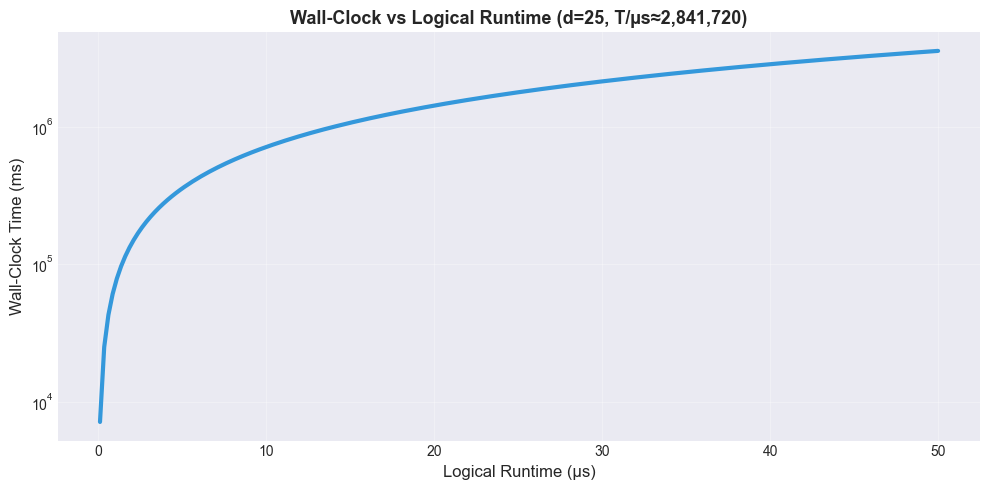

In [ ]:
# Plot: Wall-clock vs logical runtime using estimated T/µs
code_distance = 25
t_cycle = 1.0  # µs

logical_runtimes = np.linspace(0.1, 50.0, 200)

# Obtain T_per_us robustly even if cells ran out-of-order
try:
    T_per_us = est['T_per_us']  # from current params
except Exception:
    try:
        # Try to compute from available params/estimation function
        est = (params)
        T_per_us = est['T_per_us']
    except Exception:
        # Fallback default if neither exists yet
        T_per_us = 2000.0
        print("Warning: using default T_per_us=2000. Define params/est for precise value.")

wc_ms = []
for t_log in logical_runtimes:
    N_T = T_per_us * t_log
    wc_us = N_T * code_distance * t_cycle
    wc_ms.append(wc_us / 1e3)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(logical_runtimes, wc_ms, color='#3498db', linewidth=3)
ax.set_xlabel('Logical Runtime (µs)', fontsize=12)
ax.set_ylabel('Wall-Clock Time (ms)', fontsize=12)
ax.set_title(f"Wall-Clock vs Logical Runtime (d={code_distance}, T/µs≈{T_per_us:,.0f})", fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_yscale('log')
plt.tight_layout()
plt.show()


In [9]:
import math

def estimate_t_gates_per_us(params: IsingParams):
    # 1) Term counts
    N = params.N
    if params.dimension == '1D':
        ZZ = max(N - 1, 0)
        X = N
        Z = N if params.use_Z_field else 0
        M = ZZ + X + Z  # exponentials per step
    else:  # '2D'
        ZZ = 2 * N
        X = N
        Z = N if params.use_Z_field else 0
        M = ZZ + X + Z
    # Typical ranges
    # 1D: ~2N to 3N; 2D: ~3N to 4N

    # 2) Second-order Trotter steps r for window error
    # Lambda in MHz; convert to per-µs scale via Lambda * t_us (dimensionless)
    Lambda = max(params.J_MHz, params.h_MHz, params.g_MHz)
    epsilon = params.epsilon_window
    t = params.t_us
    # r ~ sqrt( alpha * N * (Lambda * t)^3 / epsilon )
    r = math.sqrt(max(params.alpha_comm * N * (Lambda * t)**3 / max(epsilon, 1e-12), 0.0))
    r = max(1, int(round(r)))

    # 3) Rotation synthesis precision per Rz
    rotations_total = r * M
    epsilon_syn = epsilon * 0.5  # half for synthesis
    delta = epsilon_syn / max(rotations_total, 1)

    # 4) T-count per Rz at precision delta (ancilla/catalysis)
    # Model: T_Rz ≈ c_T * log2(1/delta)
    c_T = 10.0  # effective constant with catalysis (tunable)
    T_Rz = max(int(round(c_T * math.log2(max(1.0/delta, 1.0)))) , 1)

    # 5) T gates per µs
    T_total = r * M * T_Rz
    T_per_us = T_total / max(t, 1e-9)

    return {
        'dimension': params.dimension,
        'N': N,
        'M_terms_per_step': M,
        'Lambda_MHz': Lambda,
        'r_steps': r,
        'rotations_total': rotations_total,
        'delta_precision': delta,
        'T_Rz': T_Rz,
        'T_total_window': T_total,
        'T_per_us': T_per_us,
    }

est = estimate_t_gates_per_us(params)
for k, v in est.items():
    print(f"{k}: {v}")


dimension: 1D
N: 100
M_terms_per_step: 199
Lambda_MHz: 1.0
r_steps: 35
rotations_total: 6965
delta_precision: 7.178750897343862e-07
T_Rz: 204
T_total_window: 1420860
T_per_us: 2841720.0


In [8]:
# Parameter input for T-gate estimation
from dataclasses import dataclass

@dataclass
class IsingParams:
    dimension: str = '1D'  # '1D' or '2D'
    N: int = 100           # Spins; for 2D, N=L^2
    J_MHz: float = 1.0     # Coupling J in MHz
    h_MHz: float = 1.0     # Transverse field h in MHz
    g_MHz: float = 0.0     # Longitudinal field g in MHz
    t_us: float = 0.5      # Evolution window in microseconds
    epsilon_window: float = 0.01  # Total error per window
    alpha_comm: float = 1.0       # Commutator constant
    use_Z_field: bool = False     # Include Z field terms

params = IsingParams()
print(params)


IsingParams(dimension='1D', N=100, J_MHz=1.0, h_MHz=1.0, g_MHz=0.0, t_us=0.5, epsilon_window=0.01, alpha_comm=1.0, use_Z_field=False)


## User Parameters: Ising Model + Trotter + Synthesis

Set the model and window parameters to estimate T-gates per microsecond for digital simulation.

- `dimension`: '1D' chain or '2D' square L×L
- `N`: number of spins (for 2D, N=L²)
- `J`, `h`, `g` in MHz: coupling strengths
- `t_us`: window length in microseconds
- `epsilon_window`: total error budget per window (default 0.01 = 1%)
- `alpha_comm`: commutator norm constant (O(1–10), default 1.0)
- `use_Z_field`: include Z terms



VISUALIZATION: Wall-Clock Time vs Logical Runtime


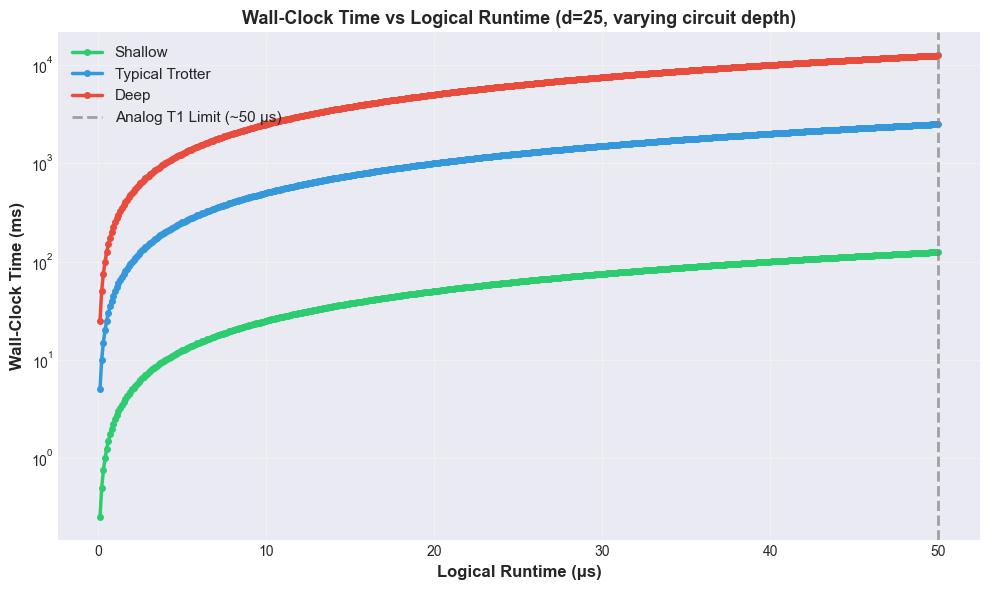


📊 Plot shows:
  • Code distance: d = 25
  • Formula: T_wall = N_T × d × t_cycle, where N_T = logical_runtime × T-gates/μs
  • Shallow: 100 T-gates/μs → ~2-20 ms for 0.1-10 μs
  • Typical: 2000 T-gates/μs → ~50-500 ms for 0.1-10 μs
  • Deep: 10000 T-gates/μs → ~250-2500 ms for 0.1-10 μs

  Vertical line: Analog T1 limit at 50 μs
  → Beyond this, analog hits decoherence limit
  → Digital + QEC can continue with error correction overhead


In [ ]:
# Plot: Wall-Clock Time vs Logical Runtime
print("\n" + "="*80)
print("VISUALIZATION: Wall-Clock Time vs Logical Runtime")
print("="*80)

# Create a range of logical runtimes and T-gate counts
logical_runtimes = np.linspace(0.1, 50.0, 500)  # 0.1 to 10 μs

# Different circuit depths (T-gate counts per μs of evolution)
t_gates_per_us = {
    'Shallow': 100,      # 100 T gates for 0.5 μs = 200 T-gates/μs
    'Typical Trotter': 2000,  # 1000 T gates for 0.5 μs = 2000 T-gates/μs
    'Deep': 10000,       # 5000 T gates for 0.5 μs = 10000 T-gates/μs
}

code_distance = 25  # Fixed at d=25 for this plot
t_cycle = 1.0       # 1 μs per cycle

fig, ax = plt.subplots(figsize=(10, 6))

# Plot for each circuit depth scenario
colors_lines = {'Shallow': '#2ecc71', 'Typical Trotter': '#3498db', 'Deep': '#e74c3c'}

for scenario_name, t_gates_rate in t_gates_per_us.items():
    wall_clock_times = []
    
    for logical_runtime in logical_runtimes:
        n_t = int(logical_runtime * t_gates_rate)
        wall_clock_us = n_t * code_distance * t_cycle
        wall_clock_times.append(wall_clock_us / 1e3)  # Convert to ms
    
    ax.plot(logical_runtimes, wall_clock_times, linewidth=2.5, 
            label=scenario_name, color=colors_lines[scenario_name], marker='o', markersize=4)

# Plot the analog limit (T1 coherence time)
analog_t1_limit = 50  # 50 μs for 100 qubits
ax.axvline(analog_t1_limit, color='gray', linestyle='--', linewidth=2, 
           label=f'Analog T1 Limit (~{analog_t1_limit} μs)', alpha=0.7)

# Formatting
ax.set_xlabel('Logical Runtime (μs)', fontsize=12, fontweight='bold')
ax.set_ylabel('Wall-Clock Time (ms)', fontsize=12, fontweight='bold')
ax.set_title('Wall-Clock Time vs Logical Runtime (d=25, varying circuit depth)', 
             fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11, loc='upper left')
ax.set_yscale('log')

plt.tight_layout()
plt.show()

print("\n📊 Plot shows:")
print(f"  • Code distance: d = {code_distance}")
print(f"  • Formula: T_wall = N_T × d × t_cycle, where N_T = logical_runtime × T-gates/μs")
print(f"  • Shallow: {t_gates_per_us['Shallow']} T-gates/μs → ~2-20 ms for 0.1-10 μs")
print(f"  • Typical: {t_gates_per_us['Typical Trotter']} T-gates/μs → ~50-500 ms for 0.1-10 μs")
print(f"  • Deep: {t_gates_per_us['Deep']} T-gates/μs → ~250-2500 ms for 0.1-10 μs")
print(f"\n  Vertical line: Analog T1 limit at {analog_t1_limit} μs")
print(f"  → Beyond this, analog hits decoherence limit")
print(f"  → Digital + QEC can continue with error correction overhead")


## Wall-Clock Time Formula: T-Gate Approach

For surface-code quantum error correction, execution time depends on the number of non-Clifford (T) gates:

$$T_{\text{wall}} = N_T \times d \times t_{\text{cycle}}$$

**Where:**
- $N_T$ = number of T gates in the circuit (depends on algorithm)
- $d$ = code distance (typically 21-30 for $p_L \lesssim 10^{-10}$)
- $t_{\text{cycle}}$ ≈ 1 µs (syndrome measurement cycle time)

**Example:** Trotter-expanded 0.5 µs evolution
- Requires ~1000 T gates (Trotter decomposition)
- Code distance d = 25 (for target error rate)
- Wall-clock time = 1000 × 25 × 1 µs = **25 ms**

**Key insight:** Even microsecond-scale quantum simulations require milliseconds of wall-clock time on a QEC system due to the overhead of continuous syndrome extraction and error correction.

This is why **analog quantum simulation without QEC** is attractive for short runtimes—it executes in real time without the T-gate latency overhead.

### Step 5: Generate Comparison Report

In [ ]:
# Generate comprehensive comparison report
report = generate_comparison_report(
    analog_sim,
    digital_est,
    title="Analog QEC vs Digital FTQC Resource Comparison"
)

# Print formatted report
print_report(report)

                 Analog QEC vs Digital FTQC Resource Comparison                 
Generated: 2025-12-12T14:57:04.214308
--------------------------------------------------------------------------------

ANALOG SIMULATION
--------------------------------------------------------------------------------
System Size:            100 qubits
System T1:              1.00 μs
Feasible Runtime:       0.00 ms
                        (0.000000 s)
Fidelity:               0.6065
Total Error:            0.393469

DIGITAL FAULT-TOLERANT COMPUTATION
--------------------------------------------------------------------------------
Logical Qubits:         100
Code Distance:          21
Physical Qubits/Logical:882

Resource Breakdown:
  Data Qubits:          88,200
  Magic State  Qubits:  176,400
  Compilation Qubits:   44,100
  TOTAL Physical Qubits:308,700

Target Runtime:         0.000000 s (0.50 μs)
Wall Clock Time:        2.79 μs
                        0.000003 s
                        0.0000 hours
Log

## Example 2: Effect of Varied T1 Times

Demonstrate how non-uniform T1 times affect system performance.

In [ ]:
# Create varied T1 times (simulating realistic qubit variations)
num_qubits = 50
t1_times = [100.0 + 30.0 * np.sin(i * 0.3) for i in range(num_qubits)]  # 70-130 μs range

print(f"Circuit with {num_qubits} qubits:")
print(f"  T1 range: {min(t1_times):.1f} - {max(t1_times):.1f} μs")
print(f"  Average T1: {np.mean(t1_times):.1f} μs")
print(f"  Std dev: {np.std(t1_times):.1f} μs")

# Simulate with varied T1s
analog_config_varied = AnalogSimulatorConfig(
    circuit_width=num_qubits,
    qubit_t1_times=t1_times,
    max_runtime_multiplier=0.5
)

analog_sim_varied = AnalogSimulator(analog_config_varied)

# Compare with uniform T1
analog_config_uniform = AnalogSimulatorConfig(
    circuit_width=num_qubits,
    default_t1=np.mean(t1_times),
    max_runtime_multiplier=0.5
)

analog_sim_uniform = AnalogSimulator(analog_config_uniform)

print(f"\nComparison:")
print(f"  Uniform T1 (avg):        {analog_sim_uniform.system_t1:.2f} μs")
print(f"  Varied T1 (realistic):   {analog_sim_varied.system_t1:.2f} μs")
print(f"  Runtime reduction:       {(1 - analog_sim_varied.feasible_runtime/analog_sim_uniform.feasible_runtime)*100:.1f}%")
print(f"\n⚠️  Note: Non-uniform T1 times reduce effective system T1 due to parallel decoherence!")

Circuit with 50 qubits:
  T1 range: 70.1 - 130.0 μs
  Average T1: 103.3 μs
  Std dev: 21.2 μs

Comparison:
  Uniform T1 (avg):        2.07 μs
  Varied T1 (realistic):   1.97 μs
  Runtime reduction:       4.5%

⚠️  Note: Non-uniform T1 times reduce effective system T1 due to parallel decoherence!


## Example 3: Circuit Width vs Runtime Trade-off

Visualize how circuit width affects feasible runtime.

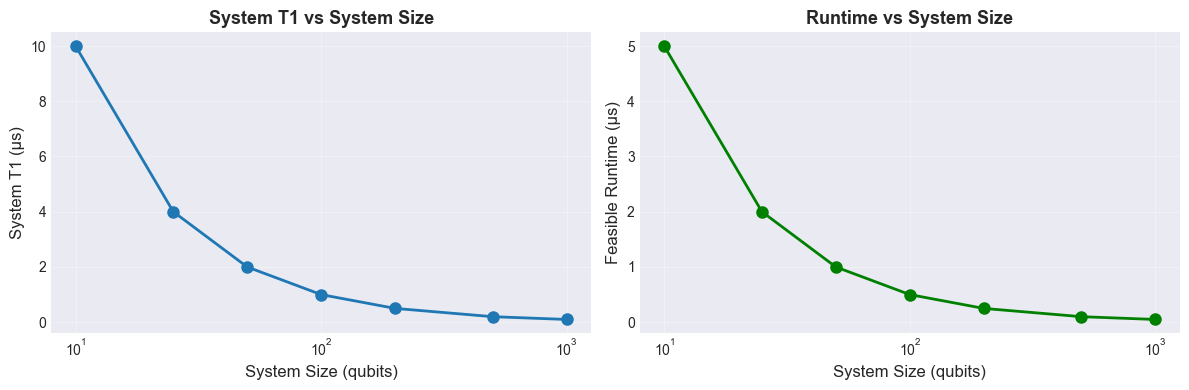

Observation: As system size increases, system T1 decreases due to
parallel decoherence (1/T1_sys = Σ 1/T1_i), limiting feasible runtime.


In [ ]:
# Parameter sweep: circuit width
widths = [10, 25, 50, 100, 200, 500, 1000]
default_t1 = 100.0  # μs

system_t1s = []
runtimes = []

for width in widths:
    config = AnalogSimulatorConfig(
        circuit_width=width,
        default_t1=default_t1,
        max_runtime_multiplier=0.5
    )
    sim = AnalogSimulator(config)
    system_t1s.append(sim.system_t1)
    runtimes.append(sim.feasible_runtime)

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1: System T1 vs Width
axes[0].plot(widths, system_t1s, 'o-', linewidth=2, markersize=8)
axes[0].set_xlabel('System Size (qubits)', fontsize=12)
axes[0].set_ylabel('System T1 (μs)', fontsize=12)
axes[0].set_title('System T1 vs System Size', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xscale('log')

# Plot 2: Runtime vs Width
axes[1].plot(widths, runtimes, 'o-', linewidth=2, markersize=8, color='green')
axes[1].set_xlabel('System Size (qubits)', fontsize=12)
axes[1].set_ylabel('Feasible Runtime (μs)', fontsize=12)
axes[1].set_title('Runtime vs System Size', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xscale('log')

plt.tight_layout()
plt.show()

print("Observation: As system size increases, system T1 decreases due to")
print("parallel decoherence (1/T1_sys = Σ 1/T1_i), limiting feasible runtime.")

## Example 4: Digital Resource Scaling

Examine how digital resources scale with problem size.

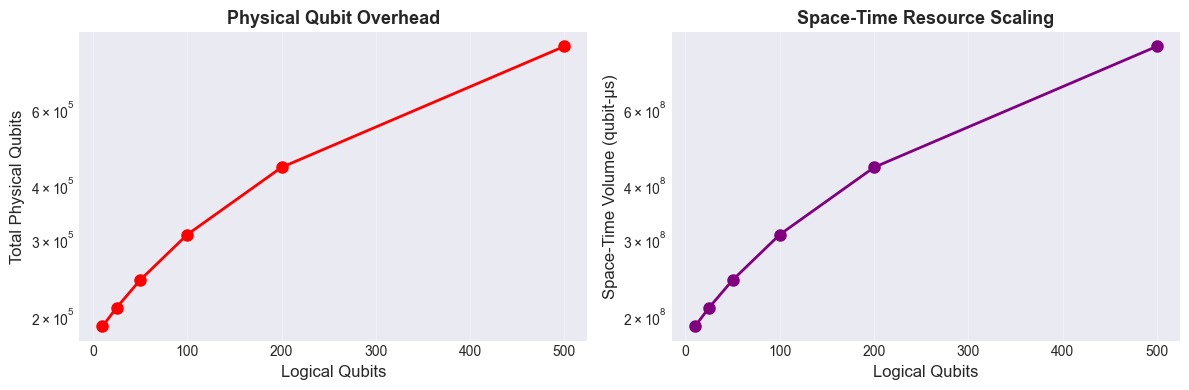

Observation: Physical qubit requirements scale significantly with
logical qubit count due to error correction overhead (~2d² per logical qubit).


In [ ]:
# Parameter sweep: logical qubit count
logical_qubit_counts = [10, 25, 50, 100, 200, 500]
runtime_us = 1000.0  # 1 ms

code_distances = []
total_physical_qubits = []
space_time_volumes = []

for n_logical in logical_qubit_counts:
    config = DigitalResourceConfig(
        logical_qubits=n_logical,
        target_runtime=runtime_us,
        digital_error_rate=0.001,
        target_logical_error_rate=1e-10,
        t_gate_count=100
    )
    est = DigitalResourceEstimator(config)
    code_distances.append(config.code_distance)
    total_physical_qubits.append(est.total_physical_qubits)
    space_time_volumes.append(est.space_time_volume)

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1: Physical Qubits vs Logical Qubits
axes[0].plot(logical_qubit_counts, total_physical_qubits, 'o-', linewidth=2, markersize=8, color='red')
axes[0].set_xlabel('Logical Qubits', fontsize=12)
axes[0].set_ylabel('Total Physical Qubits', fontsize=12)
axes[0].set_title('Physical Qubit Overhead', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_yscale('log')

# Plot 2: Space-Time Volume
axes[1].plot(logical_qubit_counts, space_time_volumes, 'o-', linewidth=2, markersize=8, color='purple')
axes[1].set_xlabel('Logical Qubits', fontsize=12)
axes[1].set_ylabel('Space-Time Volume (qubit-μs)', fontsize=12)
axes[1].set_title('Space-Time Resource Scaling', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()

print("Observation: Physical qubit requirements scale significantly with")
print("logical qubit count due to error correction overhead (~2d² per logical qubit).")

## Example 5: Comprehensive Comparison

Full analog vs digital comparison with realistic parameters.

In [ ]:
# Realistic scenario: 100-qubit quantum simulation

# Analog: Limited by T1, but direct simulation
analog_config_real = AnalogSimulatorConfig(
    circuit_width=100,
    default_t1=50.0,           # More realistic: 50 μs
    max_runtime_multiplier=0.5
)
analog_sim_real = AnalogSimulator(analog_config_real)

# Digital: Can run much longer, but with massive overhead
digital_config_real = DigitalResourceConfig(
    logical_qubits=100,
    target_runtime=100_000.0,  # 100 ms (much longer than analog)
    digital_error_rate=0.001,
    target_logical_error_rate=1e-10,
    t_gate_count=1000,
    magic_state_overhead_factor=2.0,  # Magic state cultivation overhead
    compilation_overhead_factor=1.5
)
digital_est_real = DigitalResourceEstimator(digital_config_real)

# Generate and print report
report_real = generate_comparison_report(
    analog_sim_real,
    digital_est_real,
    title="Realistic Analog vs Digital Comparison: 100-Qubit System"
)

print_report(report_real)

            Realistic Analog vs Digital Comparison: 100-Qubit System            
Generated: 2025-12-12T14:57:08.411304
--------------------------------------------------------------------------------

ANALOG SIMULATION
--------------------------------------------------------------------------------
System Size:            100 qubits
System T1:              0.50 μs
Feasible Runtime:       0.00 ms
                        (0.000000 s)
Fidelity:               0.6065
Total Error:            0.393469

DIGITAL FAULT-TOLERANT COMPUTATION
--------------------------------------------------------------------------------
Logical Qubits:         100
Code Distance:          21
Physical Qubits/Logical:882

Resource Breakdown:
  Data Qubits:          88,200
  Magic State  Qubits:  1,764,000
  Compilation Qubits:   44,100
  TOTAL Physical Qubits:1,896,300

Target Runtime:         0.100000 s (100000.00 μs)
Wall Clock Time:        558000.00 μs
                        0.558000 s
                        0.

### Key Insights Summary

In [ ]:
# Calculate key metrics
runtime_advantage = digital_est_real.config.target_runtime / analog_sim_real.feasible_runtime
qubit_overhead = digital_est_real.total_physical_qubits / analog_config_real.circuit_width
analog_st = analog_config_real.circuit_width * analog_sim_real.feasible_runtime
digital_st = digital_est_real.space_time_volume
st_overhead = digital_st / analog_st

print("\n" + "="*80)
print("KEY INSIGHTS: ANALOG VS DIGITAL QUANTUM COMPUTING")
print("="*80)

print("\n1. RUNTIME COMPARISON:")
print(f"   • Analog:  {analog_sim_real.feasible_runtime_ms:.3f} ms")
print(f"   • Digital: {digital_est_real.get_wall_clock_time_seconds()*1000:.3f} ms")
print(f"   → Digital can run {runtime_advantage:.0f}× longer")

print("\n2. QUBIT COUNT:")
print(f"   • Analog:  {analog_config_real.circuit_width} physical qubits")
print(f"   • Digital: {digital_est_real.total_physical_qubits:,} physical qubits")
print(f"   → Digital needs {qubit_overhead:.0f}× more qubits")

print("\n3. SPACE-TIME VOLUME:")
print(f"   • Analog:  {analog_st:.2e} qubit-μs")
print(f"   • Digital: {digital_st:.2e} qubit-μs")
print(f"   → Digital uses {st_overhead:.0f}× more space-time resources")

print("\n4. TRADE-OFFS:")
print("   ✓ Analog Advantages:")
print("     - Minimal qubit count (direct simulation)")
print("     - Fast execution")
print("     - Lower space-time overhead")
print("   ✗ Analog Limitations:")
print("     - Runtime limited by T1 coherence")
print("     - Circuit depth constrained by width")
print("     - No error correction")

print("\n   ✓ Digital Advantages:")
print("     - Arbitrary runtime (error correction)")
print("     - High fidelity with low logical error rates")
print("     - Fault-tolerant operation")
print("   ✗ Digital Limitations:")
print("     - Massive qubit overhead")
print("     - Large space-time volume")
print("     - Complex implementation")

print("\n5. WHEN TO USE WHICH:")
print("   → Analog: Short-time simulations, Hamiltonian evolution, NISQ algorithms")
print("   → Digital: Long algorithms, high precision required, fault-tolerance needed")
print("="*80)


KEY INSIGHTS: ANALOG VS DIGITAL QUANTUM COMPUTING

1. RUNTIME COMPARISON:
   • Analog:  0.000 ms
   • Digital: 558.000 ms
   → Digital can run 400000× longer

2. QUBIT COUNT:
   • Analog:  100 physical qubits
   • Digital: 1,896,300 physical qubits
   → Digital needs 18963× more qubits

3. SPACE-TIME VOLUME:
   • Analog:  2.50e+01 qubit-μs
   • Digital: 1.90e+11 qubit-μs
   → Digital uses 7585200000× more space-time resources

4. TRADE-OFFS:
   ✓ Analog Advantages:
     - Minimal qubit count (direct simulation)
     - Fast execution
     - Lower space-time overhead
   ✗ Analog Limitations:
     - Runtime limited by T1 coherence
     - Circuit depth constrained by width
     - No error correction

   ✓ Digital Advantages:
     - Arbitrary runtime (error correction)
     - High fidelity with low logical error rates
     - Fault-tolerant operation
   ✗ Digital Limitations:
     - Massive qubit overhead
     - Large space-time volume
     - Complex implementation

5. WHEN TO USE WHICH:
  

## Visualization: Direct Comparison

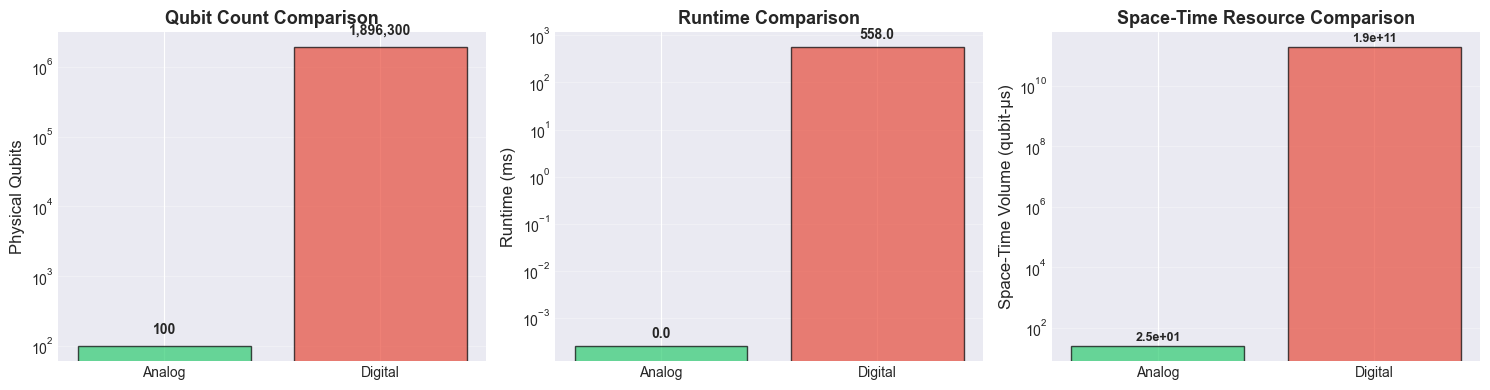

In [ ]:
# Create comparison visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Qubit Comparison
categories = ['Analog', 'Digital']
qubit_counts = [analog_config_real.circuit_width, digital_est_real.total_physical_qubits]
colors = ['#2ecc71', '#e74c3c']

axes[0].bar(categories, qubit_counts, color=colors, alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Physical Qubits', fontsize=12)
axes[0].set_title('Qubit Count Comparison', fontsize=13, fontweight='bold')
axes[0].set_yscale('log')
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(qubit_counts):
    axes[0].text(i, v*1.5, f'{v:,}', ha='center', fontsize=10, fontweight='bold')

# Plot 2: Runtime Comparison
runtimes_ms = [analog_sim_real.feasible_runtime_ms, digital_est_real.get_wall_clock_time_seconds()*1000]

axes[1].bar(categories, runtimes_ms, color=colors, alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Runtime (ms)', fontsize=12)
axes[1].set_title('Runtime Comparison', fontsize=13, fontweight='bold')
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(runtimes_ms):
    axes[1].text(i, v*1.5, f'{v:.1f}', ha='center', fontsize=10, fontweight='bold')

# Plot 3: Space-Time Volume Comparison
st_volumes = [analog_st, digital_st]

axes[2].bar(categories, st_volumes, color=colors, alpha=0.7, edgecolor='black')
axes[2].set_ylabel('Space-Time Volume (qubit-μs)', fontsize=12)
axes[2].set_title('Space-Time Resource Comparison', fontsize=13, fontweight='bold')
axes[2].set_yscale('log')
axes[2].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(st_volumes):
    axes[2].text(i, v*1.5, f'{v:.1e}', ha='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

## Conclusion

This notebook demonstrated the complete workflow for comparing analog quantum simulation with digital fault-tolerant quantum computation. The key takeaways are:

1. **System T1 Constraint**: For analog simulation, the effective system T1 is determined by parallel decoherence: $\frac{1}{T_1^{\text{sys}}} = \sum_i \frac{1}{T_1^i}$

2. **System Size-Runtime Trade-off**: Larger systems have shorter effective T1, limiting maximum runtime. Analog simulation is fundamentally a continuous-time process constrained only by coherence.

3. **Digital Overhead**: Error correction provides arbitrary runtime but at the cost of massive qubit overhead (~2d² per logical qubit) and significant magic state cultivation overhead.

4. **Application-Dependent**: The choice between analog and digital depends on the specific application requirements and runtime needs.

### Next Steps

- Experiment with different parameters and T1 times
- Try realistic T1 distributions from experimental data
- Explore different error correction codes and parameters
- Calculate crossover points for specific applications
- Validate against experimental runtime constraints